In [2]:
import numpy as np 
import polars as pl #(I was having a personal dilemma as I have always used pandas... but polars performance is out of this world)
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
import random

2024-05-20 21:39:37.848682: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-20 21:39:37.852282: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-20 21:39:37.900905: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-20 21:39:38.804291: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# **"A computer program is said to learn from experience E with respect to some class of tasks T and performance measure P, if its performance at tasks in T, as measured by P, improves with experience E.”**
That's it :D chapter finished

# Machine learning basics
This chapter is where it starts to be really difficult for me (a little bit) as the theoretical background of the book is impecable, but any example that I give you is going to make you not consider other things... so this is what I am going to do... I am going to use 4 examples
1. A random generated set that focus on two subsets distributed randomly over two focus points (don't worry I will explained little by little :D)
2. A dataset of the price of diamonds based on characteristics([Diamonds Dataset](https://www.kaggle.com/datasets/shivam2503/diamonds))
3. A very famous set of pictures called CIFAR-10 (learn a little bit more about them in [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html))
4. A set of handwritten digits called MNIST (learn a little bit more about them in [MNIST](http://yann.lecun.com/exdb/mnist/))
 
Remember is always good to properly cite your data!!!( I will do so when the project is done but until then hehe you have the links).


# How are we are going to do this?
We are going to take this roadmap for learning this chapter, this will branch off of what the chapter is teaching but it will use all of it's definitions.
1. Defining the datasets that we are going to work on, on each one we are going to define some tasks that we could do with each dataset
2. I will create a single regression algorithm for a set of points, very simple and our first approach to task.
3. I will set up a single perceptron that solves linear regression (I will give the reason why I do this below)
4. We are going to make an example of each task in 5.1.1 examples (and one more that is data generation)

\* On each example I am going to use 1 or 2 datasets and I am going to point out what part of the text I am using

\* On each example I will talk about issues that you are going to face when trying to create some algorithms

\* As we advance in this chapter I will start using tensorflow to create models and stop using 

5. We are going to make an example of subchapters 5.7, 5.8, with none of the datasets that we are using but with more simple examples, because those are difficult topics
6. I will leave space for explaining some functions that are define in the chapter

# Why are we doing this?
This chapter is mainly theorical, and each definition can be really hard to see only with that, that's why I think that if I explain the same that is in the book it will lead to nothing. Thus with examples of real life cases you can get the grasp of what we are talking 

I have place them in order on how difficulty I think it is to work on them and what we should need to consider in order to get good results. But until the next chapter this will more than enough. Before we start let's check out our data

# Dataset 1 (Random points)

In [3]:
# This part of the code is only to create the data for the random points and save it in a csv
# generate_random_dataset
# arguments:
# points = 2 (number of focus points of you dataset)
def generate_random_dataset(focus=2,n=400):
    points = []
    df = pl.DataFrame({"x":[],"y":[],"c":[]})
    df = df.select(
            pl.col("x").cast(pl.Float64).alias("x"),
            pl.col("y").cast(pl.Float64).alias("y"),
            pl.col("c").cast(pl.Int64).alias("c")
         )
    for _ in range(focus):
        x = random.uniform(-8,8 )
        y = random.uniform(-8,8 )
        points.append((x, y))
    for _ in range(n):
        choosed = np.random.choice([0,1])
        p = points[choosed]
        x = np.random.normal()
        y = np.random.normal()
        dn = pl.DataFrame({"x":[x+p[0]],"y":[y+p[1]],"c":[choosed]})
        df = pl.concat([df,dn])
    df.write_csv("datasets/random_points.csv")

In [4]:
dataset = pl.read_csv("datasets/random_points.csv") #this is the important part
print(dataset.head())
data = dataset.to_numpy()

shape: (5, 3)
┌───────────┬───────────┬─────┐
│ x         ┆ y         ┆ c   │
│ ---       ┆ ---       ┆ --- │
│ f64       ┆ f64       ┆ i64 │
╞═══════════╪═══════════╪═════╡
│ 2.618677  ┆ 1.616839  ┆ 1   │
│ 1.366612  ┆ 0.85761   ┆ 1   │
│ -0.242673 ┆ -8.444032 ┆ 0   │
│ 0.801606  ┆ 2.803869  ┆ 1   │
│ -0.483904 ┆ -7.338172 ┆ 0   │
└───────────┴───────────┴─────┘


We are going to plot it to see what this is 

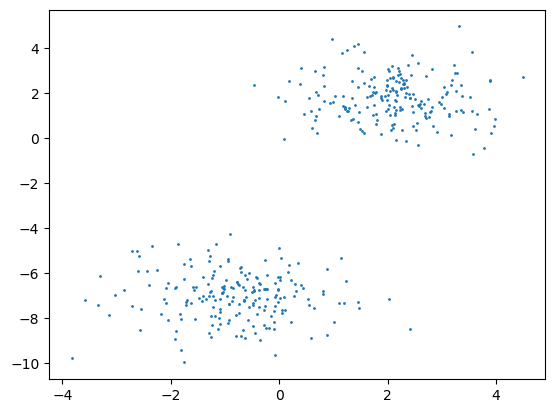

In [5]:
plt.scatter([i[0] for i in data] ,[i[1] for i in data],s=1)

This is the data set that we are working on... it is clear on what we are going to do... but please, we haven't actually set up any objective, until we have more tools, this is just data, nothing else. 
## What tasks we could perform with this datasets?
1. Are there any categories that we could define between the points?
2. If we want to divide the data in two categories how can we divide them?
3. Can we create a new point that is inside on one of the categories
4. Can we say if a point does not belong to the dataset?

# Dataset 2
For this we are going to use kaggle ([Kaggle](https://www.kaggle.com/datasets/shivam2503/diamonds?resource=download)), kaggle is a platform where you can find challeges and many datasets!

In [6]:
dataset = pl.read_csv("datasets/diamonds.csv") 
print(dataset.head())
data = dataset.to_numpy()

shape: (5, 11)
┌─────┬───────┬─────────┬───────┬───┬───────┬──────┬──────┬──────┐
│     ┆ carat ┆ cut     ┆ color ┆ … ┆ price ┆ x    ┆ y    ┆ z    │
│ --- ┆ ---   ┆ ---     ┆ ---   ┆   ┆ ---   ┆ ---  ┆ ---  ┆ ---  │
│ i64 ┆ f64   ┆ str     ┆ str   ┆   ┆ i64   ┆ f64  ┆ f64  ┆ f64  │
╞═════╪═══════╪═════════╪═══════╪═══╪═══════╪══════╪══════╪══════╡
│ 1   ┆ 0.23  ┆ Ideal   ┆ E     ┆ … ┆ 326   ┆ 3.95 ┆ 3.98 ┆ 2.43 │
│ 2   ┆ 0.21  ┆ Premium ┆ E     ┆ … ┆ 326   ┆ 3.89 ┆ 3.84 ┆ 2.31 │
│ 3   ┆ 0.23  ┆ Good    ┆ E     ┆ … ┆ 327   ┆ 4.05 ┆ 4.07 ┆ 2.31 │
│ 4   ┆ 0.29  ┆ Premium ┆ I     ┆ … ┆ 334   ┆ 4.2  ┆ 4.23 ┆ 2.63 │
│ 5   ┆ 0.31  ┆ Good    ┆ J     ┆ … ┆ 335   ┆ 4.34 ┆ 4.35 ┆ 2.75 │
└─────┴───────┴─────────┴───────┴───┴───────┴──────┴──────┴──────┘


As you might see... it is imposible for us to graph this... as we have many many Features, what are attributes? well good question... we can start our definition 
### Dataset, objects, features, attributes
A dataset is set that contains objects, objects, as we will call all rows in a dataset, are instances of infomrmation that share a number of characteristics, this characteristics are what we called a feature, meaning a feature is something that characterize a set of objects in a dataset. And the attribute is the value of that feature inside an object. That is a toungue twister hehe, using the example above. the first row represent an object (in this case a diamond), a row is a feature (an example is color, meaning color is a feature of a diamond) and finally an atrribute is the value that characterises the object with respect a feature (meaning for example E in the feature color of the first diamond).

_Was this definition necessary? No... but I have to self promote a bit, I worked on a paper that makes a new way of understanding the relation between features, so I usually use this definitions when talking about machine learning you should read it after you finish the book... I am no expert but is quite good :D_

We cannot visualize all of them but we can do something interesting, we can take two of the features and then graph their relationship. Only focusing on that features :D

In [7]:
#First let's get the features
features = [i.name  for i in dataset.get_columns() if i.name != ""]
print(f"features = {features}")
#First let's get the features
types = [i.dtype  for i in dataset.get_columns() if i.name != ""]
print(f"types = {types}")

features = ['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y', 'z']
types = [Float64, String, String, String, Float64, Float64, Int64, Float64, Float64, Float64]


In [8]:
# We are going to create a function that takes two of this features and graph the relation

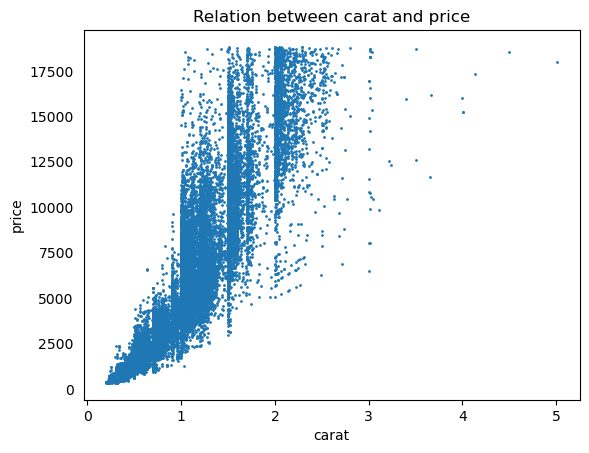

In [9]:
fig = plt.figure()
ax = fig.add_subplot()
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    left=False,        # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) 
def plot_relation_between_to_features(f1,f2,fig,ax,title=True,label_x=True,label_y=True):
    x = dataset.get_column(f1).to_numpy()
    y = dataset.get_column(f2).to_numpy()
    ax.scatter(x,y,s=1)
    if(label_x):
        ax.set_xlabel(f1)
    if(label_y):
        ax.set_ylabel(f2)
    if(title):
        ax.set_title(f"Relation between {f1} and {f2}")
plot_relation_between_to_features("carat","price",fig,ax)

Really nice right? We are going to do the same for all data that is a number... at first we are going to only do this because until now we haven't even met a case of categorical data and we don't even now what to do when we have an attribute that says Premium... how do you multiply Premium times 2... We are going to learn it just a little bit latter

In [10]:
numerical_features = [i  for i in features if dataset.get_column(i).dtype in [pl.Float64,pl.Int64]]
print(f"numerical_features = {numerical_features}")

numerical_features = ['carat', 'depth', 'table', 'price', 'x', 'y', 'z']


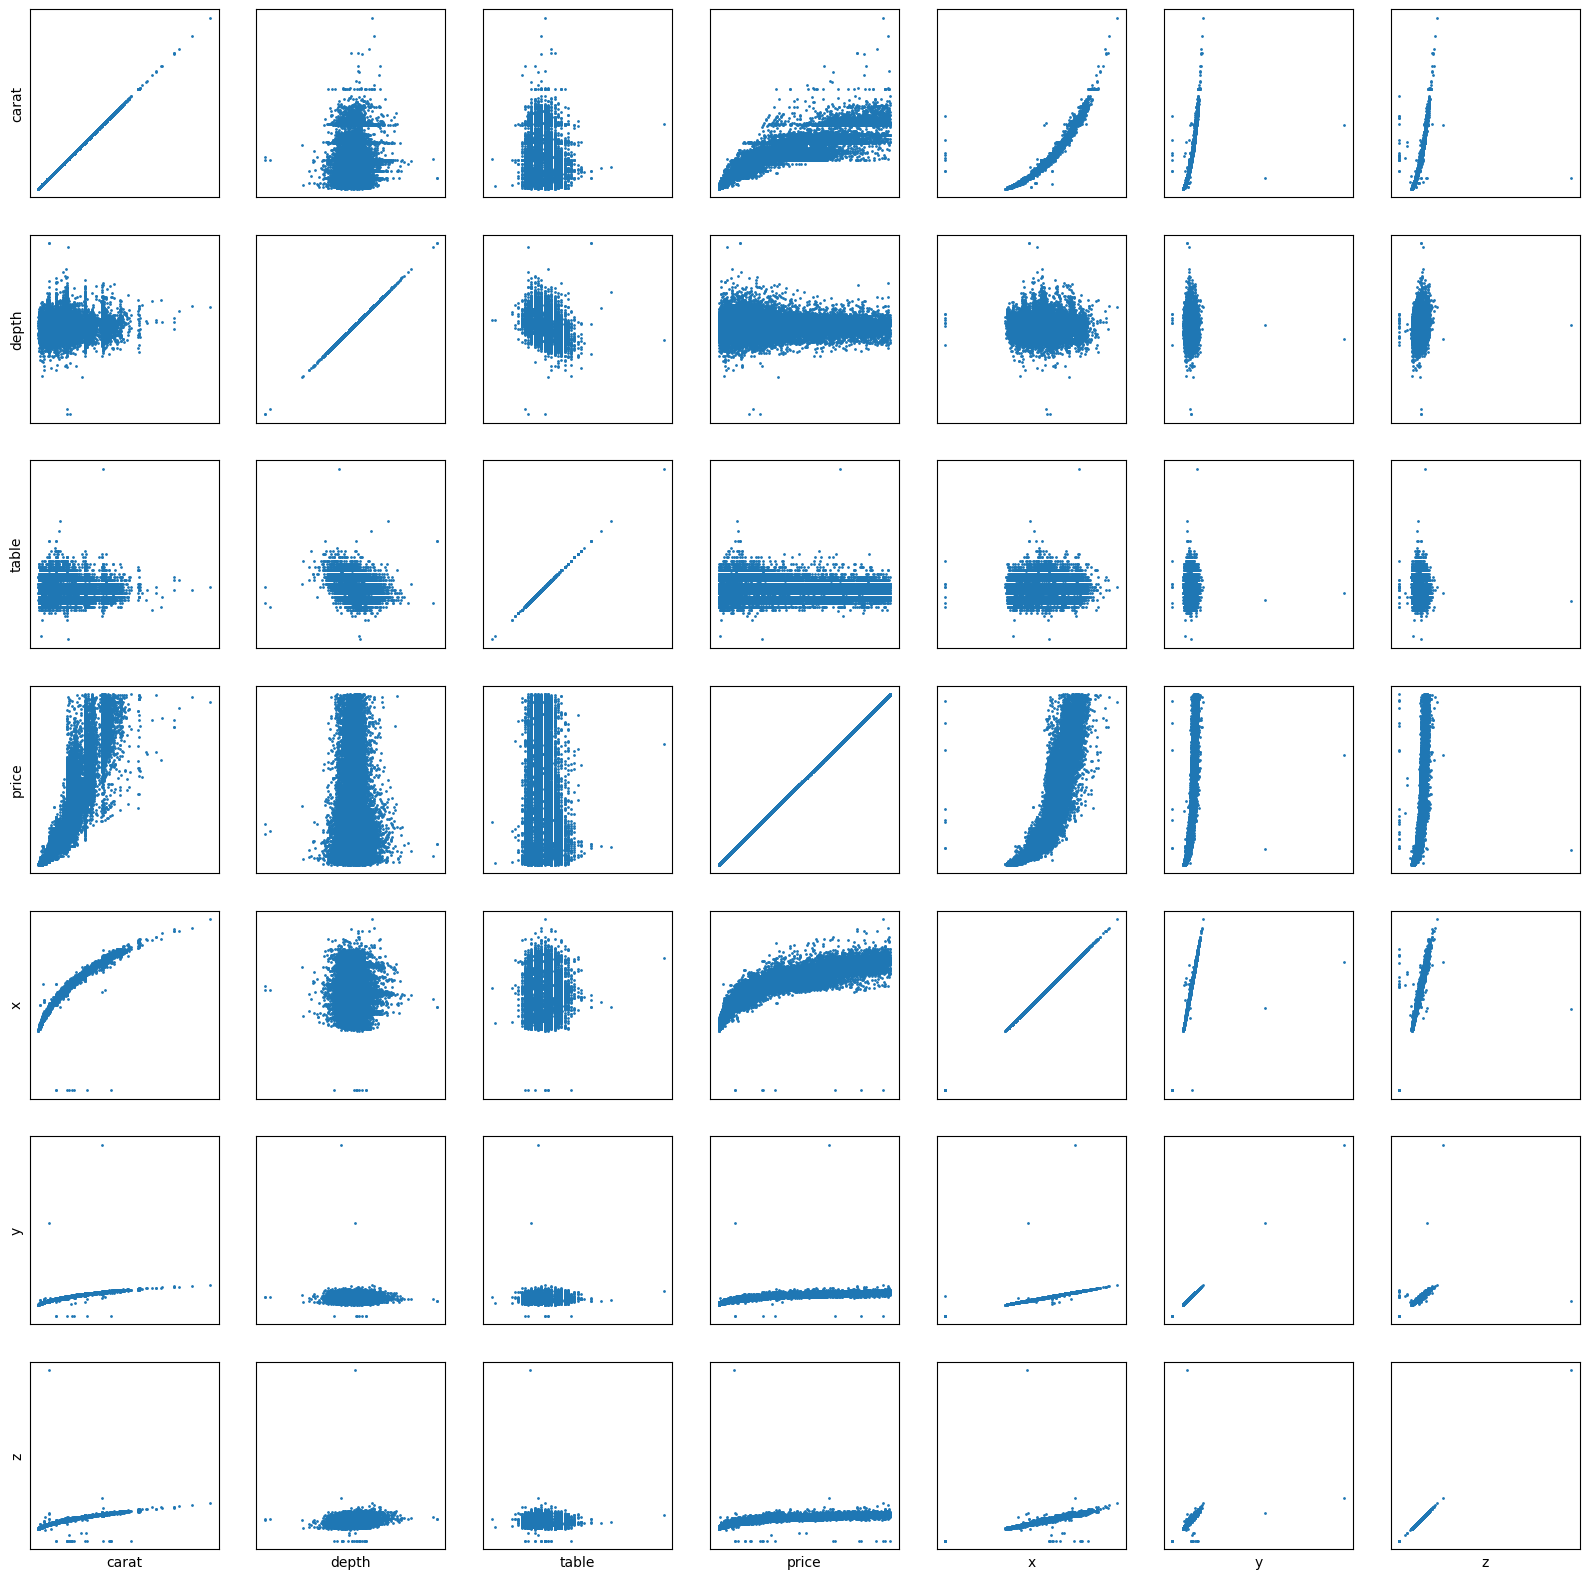

In [11]:
fig, axes = plt.subplots(ncols=7,nrows=7,figsize=(20,20))
for i in range(len(axes)):
    for j in range(len(axes[i])):
        ax = axes[i][j]
        ax.set_xticks([])
        ax.set_yticks([])
        label_x = i==len(numerical_features)-1
        label_y = j==0
        plot_relation_between_to_features(numerical_features[j],numerical_features[i],fig,ax,title=False,label_x=label_x,label_y=label_y)

Nice right? so well that is our dataset

## Tasks
1. How can we put a price to a new diamond and be certain that is acording to the market?
2. Is there any relation between some of the features? Meaning we can anwser questions like, if the size of the diamond is x, what should be the value y?
3. Are some of the variables not necessary? meaning can I drop some feature and still get a good result?
4. Can we predict the size of the diamond based on the carat?
5. Are there values in our datasets that are simply 

# Dataset 3

In [12]:
dataset = tf.keras.datasets.mnist.load_data()

In [13]:
images = dataset[1][0]
categories = dataset[1][1]

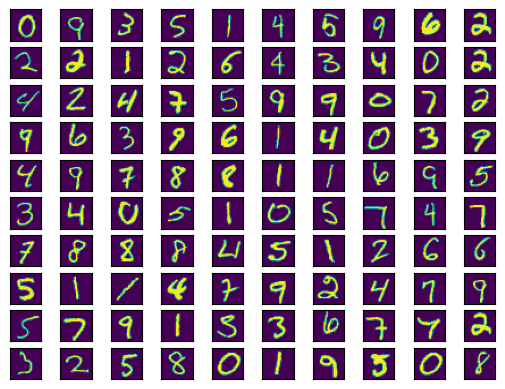

In [14]:
fig, *ax = plt.subplots(nrows=10,ncols=10)
axes = ax[0]
for i in range(10):
    for j in range(10):
        a = np.random.randint(0,1000)
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([])
        axes[i][j].imshow(images[a])
plt.show()

## Tasks
1. Can I create an algorithm that can "read" the number that is written?
2. Do all 1's have the same characteristics?
3. Can I draw a number and my algorithm be able to recognize it?
4. What happens if I give the input of my algorithm a letter?
5. Can I make the machine draw it's numbers?

# Dataset 4
We are going to start using tensor flow... until what we have, we actually don't have knowledge of tensor flow or what is even a tensor... but well, tensor flow library has a submodule of datasets, that is going to be very useful right now :D

In [15]:
# To download data
dataset = tf.keras.datasets.cifar10.load_data()

In [16]:
#In this dataset we have the images and the categories it has
images = dataset[1][0]
categories = dataset[1][1]

In [17]:
print(images.shape)
print(categories.shape)

(10000, 32, 32, 3)
(10000, 1)


We have then 10000 images of 3 layers (RGB) and each layer 32 by 32 pixels, let's see an image

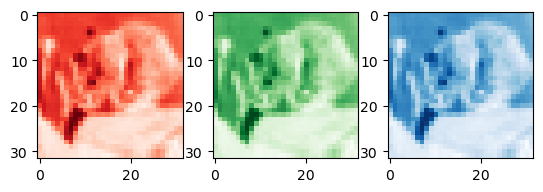

In [18]:
#First image
fig,ax = plt.subplots(ncols=3)
ax[0].imshow(images[0][:,:,0],cmap="Reds")
ax[1].imshow(images[0][:,:,0],cmap="Greens")
ax[2].imshow(images[0][:,:,0],cmap="Blues")
#If you are daltonic, I'm sorry the next example will work better for you

Cool that is clearly a...hmmm... 

In [19]:
print(categories[0])

[3]


That is clearly a category 3 hehe, each image have this layers, because when you overlay those three images you can get all colors that a computer can handle, thus if we plot the whole image

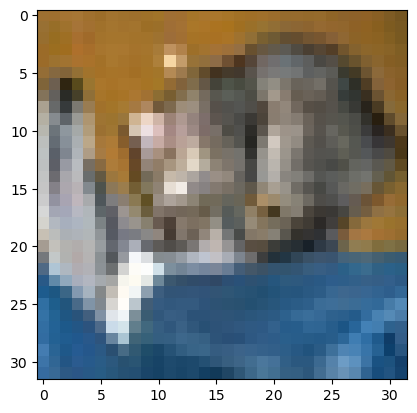

In [20]:
plt.imshow(images[0])

In [21]:
#Let plot more figures of each category

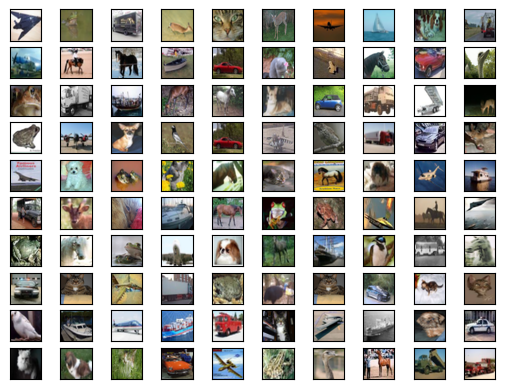

In [22]:
fig, *ax = plt.subplots(nrows=10,ncols=10)
axes = ax[0]
for i in range(10):
    for j in range(10):
        a = np.random.randint(0,1000)
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([])
        axes[i][j].imshow(images[a])
plt.show()

## Tasks
1. Can the algorithm categorize an image?
2. Are there better techniques to do this prediction?
3. Is there a way to do it that is not the same as the numbers?
4. Can we create an image based on out data? (This might be the only one that I am going to give you the spoiler that is not probable :()

We are going to look further in the next steps.

# 2. Linear Regression 
The first approach to machine learning is linear regresssion, why? because machine learning is when there is an algorithm that learns from data and as more data is presented or "used" its performance is improved, an by improved we are going to use the definitions on the book, the Task T, is going to be predict y using x, we are going to set up the Performance P as how close the algorithm is based on the actual data (Don't worry we are going to define what close means). Linear regression is actually been around since the 19th century and is used to check the relation between two variables. In it's simpler form. Thus we use this technique to predict the response of a variable based on a value. Question's that we could answer with this algorithm
1. If we have x what can we expect y to be?
2. If the response was y, what we assume the x was?
3. Are this two variables related?
4. If x grows, y grows?

If you are in a situation where you have this question you can use linear regression to answer it.

Okay so what dataset are we are going to use it on? In this case based on what I just told you, it might be easy to predict what data I am going to use... the number 4... hehe jk. We are going to use number 1, the diamond dataset, but we are going to reduce it, we are going to check only price and carat. In order to make simple linear regression

In [23]:
dataset = pl.read_csv("datasets/diamonds.csv") 
print(dataset.head())
data = dataset.to_numpy()

shape: (5, 11)
┌─────┬───────┬─────────┬───────┬───┬───────┬──────┬──────┬──────┐
│     ┆ carat ┆ cut     ┆ color ┆ … ┆ price ┆ x    ┆ y    ┆ z    │
│ --- ┆ ---   ┆ ---     ┆ ---   ┆   ┆ ---   ┆ ---  ┆ ---  ┆ ---  │
│ i64 ┆ f64   ┆ str     ┆ str   ┆   ┆ i64   ┆ f64  ┆ f64  ┆ f64  │
╞═════╪═══════╪═════════╪═══════╪═══╪═══════╪══════╪══════╪══════╡
│ 1   ┆ 0.23  ┆ Ideal   ┆ E     ┆ … ┆ 326   ┆ 3.95 ┆ 3.98 ┆ 2.43 │
│ 2   ┆ 0.21  ┆ Premium ┆ E     ┆ … ┆ 326   ┆ 3.89 ┆ 3.84 ┆ 2.31 │
│ 3   ┆ 0.23  ┆ Good    ┆ E     ┆ … ┆ 327   ┆ 4.05 ┆ 4.07 ┆ 2.31 │
│ 4   ┆ 0.29  ┆ Premium ┆ I     ┆ … ┆ 334   ┆ 4.2  ┆ 4.23 ┆ 2.63 │
│ 5   ┆ 0.31  ┆ Good    ┆ J     ┆ … ┆ 335   ┆ 4.34 ┆ 4.35 ┆ 2.75 │
└─────┴───────┴─────────┴───────┴───┴───────┴──────┴──────┴──────┘


In [24]:
carat = dataset["carat"]
price = dataset["price"]

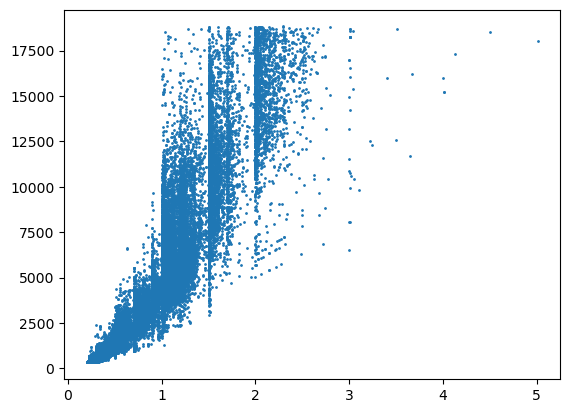

In [25]:
#First let's graph the values
plt.scatter(carat,price,s=1)

But that looks a little bit hard... not because we cannot do it, but beacuse is difficult to see what we want to see, so lets start simple, 2 diamonds that we take

In [26]:
subset = dataset[["carat","price"]][[1,100]]
subset

carat,price
f64,i64
0.21,326
0.75,2760


That means our first diamond (object 1) has 0.23 carat's and has a price of 326 dolars, the second object has 0.75 carats and cost 2760 dollars, nice, we can work in that

Okay we are going to graph it

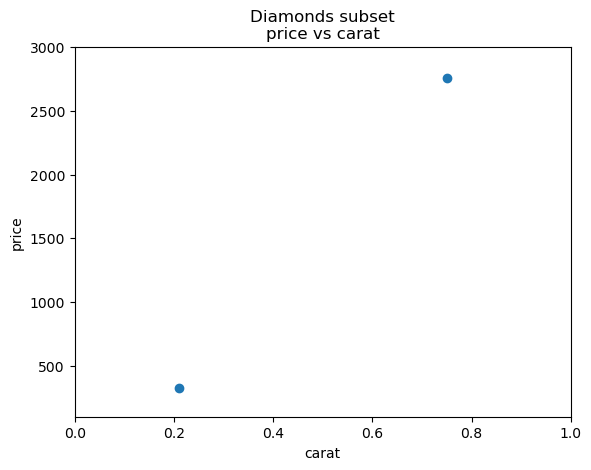

In [27]:
def plot_subset(subset):
    plt.scatter(subset["carat"],subset["price"])
    plt.xlim([0,1])
    plt.ylim([100,3000])
    plt.xlabel("carat")
    plt.ylabel("price")
    plt.title("Diamonds subset\nprice vs carat")
plot_subset(subset)

We can go know step by step... what is linear regression? linear regression is an algorithm that tries to understand the linear relation between two variables by minimizing the error it exits in our prediction and the data... linear relation what does that mean? well in this case we have the variable price and carats, we want to find the price based on the carat, (from now own I am going to say x when I refer to carat and y when I refer to price). Thus we want to find the linear function
$$y=ax+b$$
that best represents our data, we have to points as right now, we can use simple math to solve this, as we know that both diamonds are "answers" to this equation, then we have a very simple system of equations
$$326 = a*0.21 +b $$
$$2760 = a*0.75+ b$$
then 
$$a = \frac{2760-326}{0.75-0.21}$$

In [28]:
(2760-326)/(0.75-0.21)

4507.407407407407

then $a=4507.41$ also
$$b = -0.21*4507.41 + 326$$

In [29]:
-(0.21*4507.41 - 326)

-620.5560999999999

and $b=-620.55$. Thus our prediction is that the linear function that relates the cartas and the price is
$$y = 4507.41x - 620.55$$
Let's graph it

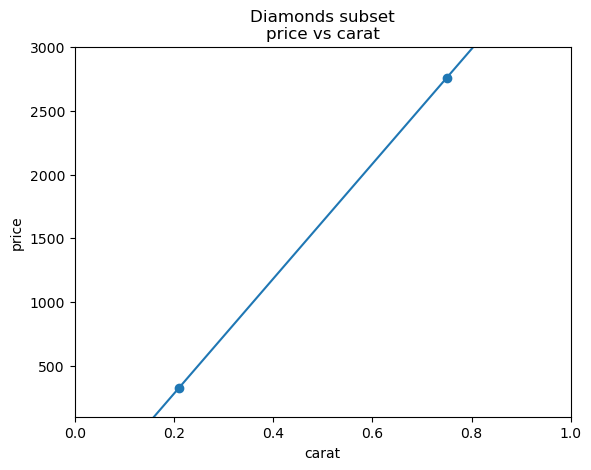

In [30]:
plot_subset(subset)
x = np.linspace(0,1,100)
def prediction(x):
    return 4507.41*x-620.55
plt.plot(x,prediction(x))

That's look nice, let's see if it suffices our task

In [31]:
print(f"carat={0.21} then price={prediction(0.21)}")
print(f"carat={0.75} then price={prediction(0.75)}")

carat=0.21 then price=326.00609999999995
carat=0.75 then price=2760.0074999999997


That is perfect (psudo-perfection hehe, remember perfections is imposible because of precision), that's nice, we created our model based on only two values :D, what happens if we wanted to add a third one, let's use then this dataset

shape: (3, 2)
┌───────┬───────┐
│ carat ┆ price │
│ ---   ┆ ---   │
│ f64   ┆ i64   │
╞═══════╪═══════╡
│ 0.21  ┆ 326   │
│ 0.75  ┆ 2760  │
│ 0.98  ┆ 2898  │
└───────┴───────┘


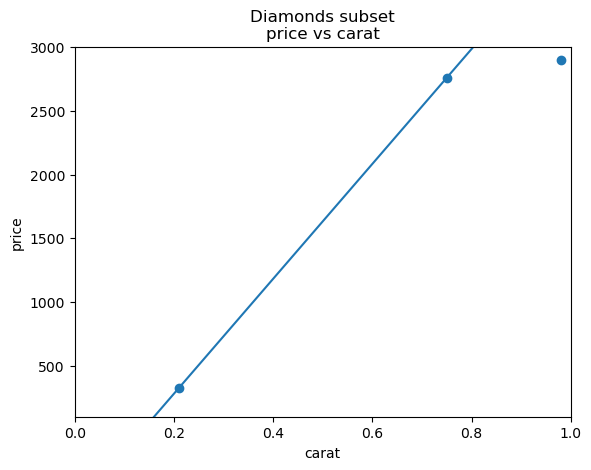

In [32]:
subset = dataset[["carat","price"]][[1,100,1002]]
print(subset)
plot_subset(subset)
plt.plot(x,prediction(x))

That looks nice but :( it appears that our new value is making things hard, this new diamond has 0.98 carat and costs 2898, if we are going to sell a diamond of 0.98 carat's we are going to price it to

In [33]:
prediction(0.98)

3796.7118

OMG we overpriced it!! and by a lot! exactly by

In [34]:
(prediction(0.98)- subset[2]["price"])

price
f64
898.7118


By 898.71 dollars :(, no one is going to buy that, they are gonna say that in another place someone sold it for 900 dollars less than our price. Do not worry, Linear regression is here to help us! Let's go step by step, we now have three points of data

In [35]:
print(subset)

shape: (3, 2)
┌───────┬───────┐
│ carat ┆ price │
│ ---   ┆ ---   │
│ f64   ┆ i64   │
╞═══════╪═══════╡
│ 0.21  ┆ 326   │
│ 0.75  ┆ 2760  │
│ 0.98  ┆ 2898  │
└───────┴───────┘


First we are going to use what we used before, the idea of how to minimize something, but what is that something? well that is good question, we want to minimize the error and maximize the precision on our predictions. Then this is the first not intuitive idea that I am going to say. We have a way of checking how much appart are two values, the distance, if you are two meters from your target, then have an error of 2 meters. Suppose that we want to check how far appart we are from the correct price, then simply we could say the we are 
$$(y-\hat{y})^2$$
(Why this way? because we want to handle only positives)
appart from the actual value. Why absolute value? because we don't say we don't make a distinction between 300 underpriced or overpriced, we are 300 away of the price that we want. Now we have many diamonds, and we want to find a linear regression that minimizes for all of them, then what is a good way to keep track of it, well simple, let's sum all of the errors for each diamond, and then get an average of the error for each point, for that we just divide for the number of points we are training
$$\frac{1}{n}\sum_{i=0}^{n}(y-\hat{y})^2$$
That's cool, we want to minimize that, that is how we are going to measure our performance P, by saying that our prediction is good when the error is low, or as low as we can make it. Then how can we do it... do you remember how do we use gradient descent to find step by step the minimum, let us do the same :D

Thus we have a function to check each points
$$e(a,b) = (y_i-\hat{y}_i)^2$$
Wait? a and b? why? remember, what are we looking for!!! we are looking for the coefficients of
$$y = ax+b$$
So remember the variables here are a and b! thus now we can start working on some ideas, we are going to start with a random set of $[a_0,b_0]$ and we have to go step by step closer to the values that minimize it! What are the steps? well you are going to see, first let's get what we need, the gradient, remember until now is our only tool for getting to the minimu, then
$$\nabla e = [\frac{\partial e}{\partial a},\frac{\partial e}{\partial b}]$$
How do we derive that? well we are missing one final step, what is $\hat{y}$? y is the value we get from the data, but $\hat{y}$ we created and we said that for an x our prediction is $\hat{y}$ then
$$\hat{y}=ax+b$$
Thus with our new function 
$$e(a,b) = (y_i-ax_i-b)^2$$
Now what is our gradient with this new info 
$$\nabla e = [2(y_i-ax_i-b)(-x_i),2(y_i-ax_i-b)*-1]$$
Then how are going to improve each time our performance? step by step, and what is our first step? this might look familiar
$$[a_1,b_1] = [a_0,b_0] - \epsilon \nabla e(x_0,y_0)$$
Why only the first point? well that is because we are going to use what we call the stochastic gradient descent, where the training is going to improve as we fed more and more information, in this case as we have only 3 points, we are going to 

In [36]:
#error
def error(y,y_pred):
    return (1/1200)*np.sum((np.array(y)-np.array(y_pred))) #I am using 1200 as we are runnning the same points 400 each
def gradient(x,y,a,b):
    return np.array([2*(y-x*a-b)*(-x),-2*(y-x*a-b)])
def pred(x,a,b):
    return x*a + b 

#train
def step(x,y,a,b,subset,epsilon=0.1):
    error_current_a = error(np.array(subset['price']),pred(np.array(subset['carat']),a,b))
    grad = gradient(x,y,a,b)
    return np.array([a,b])-epsilon*grad

In [37]:
def train(n):
    a,b = [4700,500]
    a_s = [a]
    b_s = [b]
    errors = [error(subset["price"],pred(np.array(subset['carat']),a,b))]
    for i in range(n):
        a,b = step(np.array(subset['carat'][0]),np.array(subset['price'][0]),a,b,subset,epsilon=0.1)
        a,b = step(np.array(subset['carat'][1]),np.array(subset['price'][1]),a,b,subset,epsilon=0.1)
        a,b = step(np.array(subset['carat'][2]),np.array(subset['price'][2]),a,b,subset,epsilon=0.1)
        errors.append(error(subset["price"],pred(np.array(subset['carat']),a,b)))
        a_s.append(a)
        b_s.append(b)
    return a,b,a_s,b_s,errors
a,b, *results= train(400)
print(a,b)

3419.4596156957127 -249.36415178316634


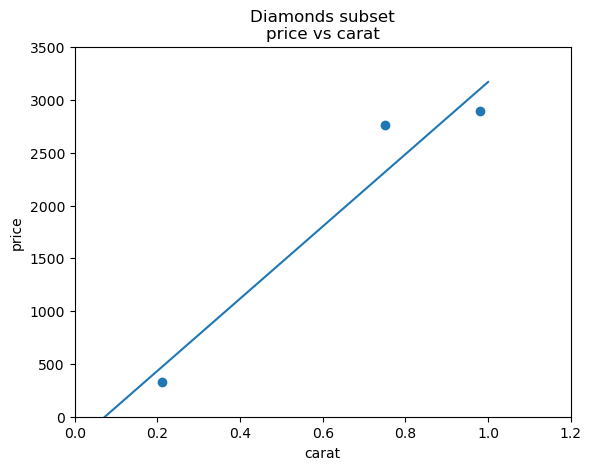

In [38]:
x = np.linspace(0,1,100)
subset = dataset[["carat","price"]][[1,100,1002]]
plot_subset(subset)
def prediction(x):
    return x*a + b
plt.xlim([0,1.2])
plt.ylim([0,3500])
plt.plot(x,prediction(x))

Okay but this line seems worse :(, There is not of the true values inside the line... well yes but if you asked me that I would ask you, what was our task? Are we creating a model that perfectly finds the value on the dataset? Or are looking for a model that best represents our data? Are we not looking for a model that minimizes errors? I am going to give you an example on what is happening! The next few slides honestly are just so I can practice animation with matplot lib so I will try my best

In [39]:
a_s = results[0]
b_s = results[1]
errors = results[2]

In [40]:
import matplotlib.animation as animation

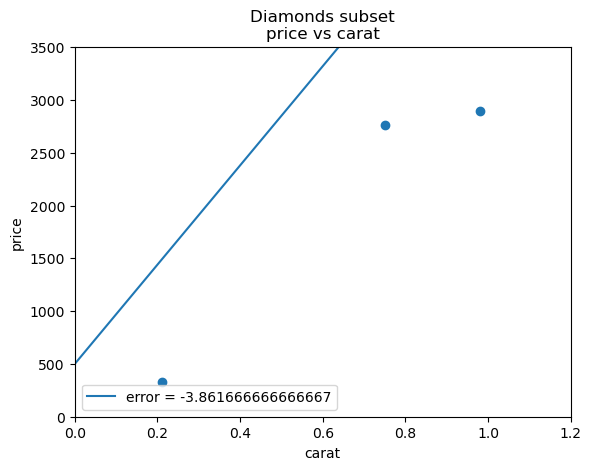

In [72]:
from IPython.display import HTML

a_s = results[0]
b_s = results[1]
errors = results[2]

x = np.linspace(0,1,100)
fig,ax = plt.subplots()
ax.set_xlim([0,1.2])
ax.set_ylim([0,3500])
line = ax.plot(x,x*a[0]+b[0],label=f"error = {errors[0]}")[0]
ax.scatter(subset["carat"],subset["price"])
ax.set_xlabel("carat")
ax.set_ylabel("price")
ax.set_title("Diamonds subset\nprice vs carat")
legend = plt.legend()
def update(i):
    global legend
    x = np.linspace(0,1,100)
    y = x*a_s[i] + b_s[i]
    line.set_xdata(x)
    line.set_label(f"error = {errors[i]}")
    line.set_ydata(y)
    legend.remove()
    legend = plt.legend()
    return (line,legend)
ani=animation.FuncAnimation(fig=fig, func=update, frames=100)
HTML(ani.to_html5_video())

So you might have noticed that with every step we take (like The Police, ask your parents why that is funny) error is going down, so our algorithm is working great!!, actually is working better than expected hehe. Okay so what should we do next? well easy, add more points, and see how it changes. I am going to define some functions first!

In [91]:
def check_results(subset,n,step=step):
    _,_,*results = train_subset(subset,n,step)
    a_s = results[0]
    b_s = results[1]
    errors = results[2]

    fig,ax = plt.subplots()
    xmin,xmax = [subset['carat'].min()-0.1,subset['carat'].max()+0.1]
    ymin,ymax = [subset['price'].min()-100,subset['price'].max()+100]
    x = np.linspace(xmin,xmax,100)
    ax.set_xlim([xmin,xmax])
    ax.set_ylim([ymin,ymax])
    ax.scatter(subset["carat"],subset["price"])
    ax.set_xlabel("carat")
    ax.set_ylabel("price")
    ax.set_title("Diamonds subset\nprice vs carat")

    line = ax.plot(x,x*a[0]+b[0],label=f"error = {errors[0]}")[0]

    legend = plt.legend()

    def update(i):
        global legend
        y = x*a_s[i] + b_s[i]
        line.set_xdata(x)
        line.set_label(f"error = {errors[i]}")
        line.set_ydata(y)
        legend.remove()
        legend = plt.legend()
        return (line,legend)

    ani=animation.FuncAnimation(fig=fig, func=update, frames=n)
    return ani.to_html5_video()

def train_subset(subset,n,step):
    a,b = [4700,500]
    a_s = [a]
    b_s = [b]
    errors = [error(subset["price"],pred(np.array(subset['carat']),a,b))]
    for i in range(n):
        for j in range(len(list(subset['carat']))):
            a,b = step(np.array(subset['carat'][j]),np.array(subset['price'][j]),a,b,subset,epsilon=0.1)
        errors.append(error(subset["price"],pred(np.array(subset['carat']),a,b)))
        a_s.append(a)
        b_s.append(b)
    return a,b,a_s,b_s,errors


Now that the functions are done, we can go adding one point each time an see how it looks. We are going to see that in our approach using **stochastic gradicent descent**, where we train point by point, many times is going to take more and more time, so what we are going to do next is analyzing what is called batch training, or **batch gradient descent**

CPU times: user 5.59 s, sys: 123 ms, total: 5.72 s
Wall time: 5.86 s


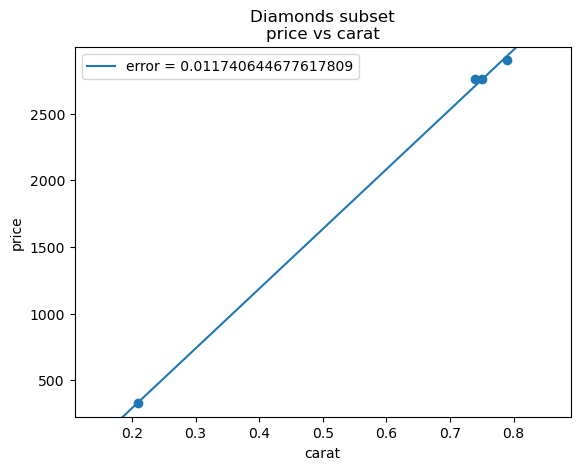

In [86]:
%%time
# 4 points
subset = dataset[["carat","price"]][[1,100,102,1004]]
HTML(check_results(subset,100))

CPU times: user 5.75 s, sys: 149 ms, total: 5.9 s
Wall time: 6.04 s


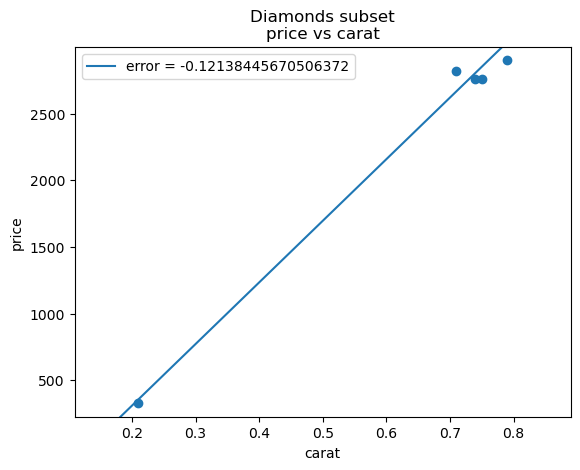

In [88]:
%%time
# 5 points
subset = dataset[["carat","price"]][[1,100,102,1004,500]]
HTML(check_results(subset,100))

CPU times: user 5.74 s, sys: 168 ms, total: 5.91 s
Wall time: 6.06 s


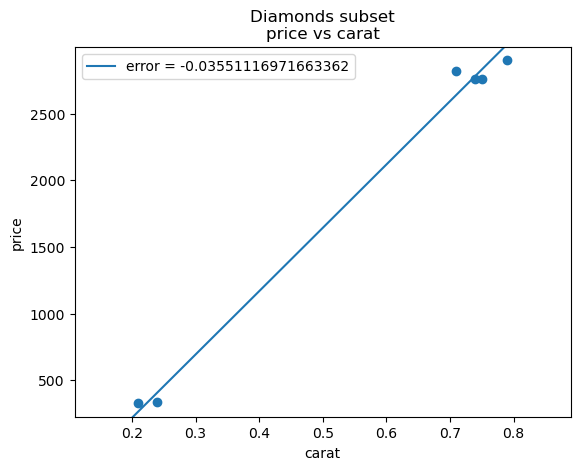

In [89]:

%%time
# r65 points
subset = dataset[["carat","price"]][[1,100,102,1004,500,5]]
HTML(check_results(subset,100))

CPU times: user 6.06 s, sys: 125 ms, total: 6.18 s
Wall time: 6.33 s


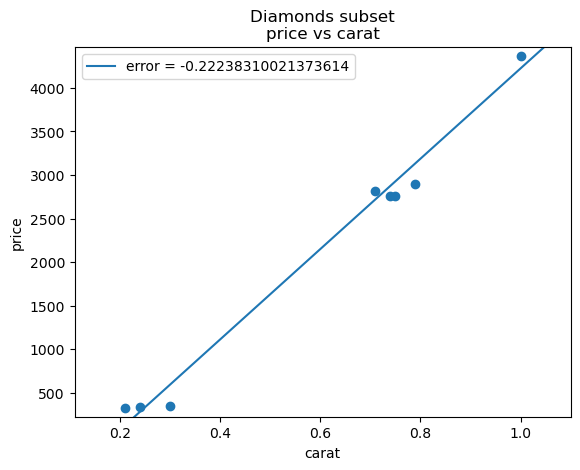

In [90]:
%%time
# 10 points
subset = dataset[["carat","price"]][[1,100,102,1004,500,5,20,8200]]
HTML(check_results(subset,100))

I dont know about you but that is cool, now what happens if we get a little crazy and try to do for 200 points

CPU times: user 32.3 s, sys: 584 ms, total: 32.9 s
Wall time: 33.3 s


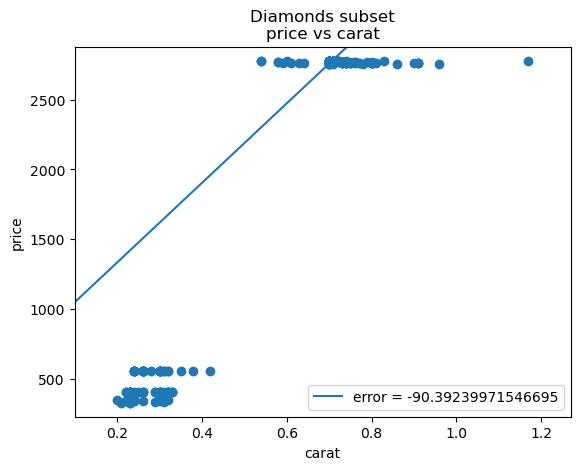

In [95]:
%%time
# 10 points
subset = dataset[["carat","price"]][0:200]
HTML(check_results(subset,500))

Well that did not work :D, what could have happend? Is difficult to say, but there could be different reasons, our algorithm is flawed, the data set is working weirdly with our dataset, and last reason, computational power. In this case what are we going to do is changing the algorithm to see if we could help sort it out. What are we going to do? We are going                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [105]:
import math

In [106]:
math.gcd(6099,2166)

57

In [109]:
i = 0
def gcd(m, n):
    global i
    i +=1
    r = m % n
    if r == 0 and r < n:
        return n
    return gcd(n, r)
for j in range(2):
    
print(i

IndentationError: expected an indented block after 'for' statement on line 9 (2020155446.py, line 11)